## TensorFlow 및 기타 라이브러리 가져오기

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0-rc1

In [6]:
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [1]:
import tensorflow
print(tensorflow.__version__)

2.0.0-rc1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import shape
from tensorflow import math
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
2.0.0-rc1


![대체 텍스트](https://drive.google.com/uc?id=1OCoK4me3T3EcaEm6H-MobpVG45LrNRrh)

In [0]:
# network parameters
original_dim=784
input_shape = (original_dim,)
intermediate_dim = 512
batch_size = 64
latent_dim = 2
epochs = 3

## MNIST 데이터 셋 로드

In [4]:
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
 # 이미지 픽셀의 모든 값을 0~1 사이로 정규화
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
 # 28x28 이미지를 크기 784의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape,x_test.shape)

(60000, 784) (10000, 784)


## VAE 모델생성
![대체 텍스트](https://drive.google.com/uc?id=1iNNT4PBS3dUeJ4ZYPmqWaU_7-ZUJRYyg)

### (1) Encoder 생성

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_shape (InputLayer)        [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder_hidden1 (Dense)         (None, 512)          401920      input_shape[0][0]                
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        encoder_hidden1[0][0]            
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 2)            1026        encoder_hidden1[0][0]            
____________________________________________________________________________________________

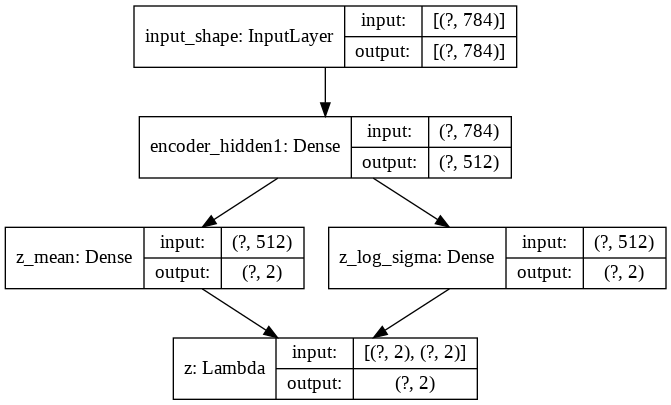

In [5]:
# Z 샘플링 함수 생성
def sampling(args):
    z_mean, z_log_var = args
    batch = shape(z_mean)[0]
    dim = shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
    epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
    return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon
# 인코더 모델을 생성합니다.
# 입력단에는 Input shape를 지정해줍니다.
inputs = layers.Input(shape=input_shape, name='input_shape')
encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)
# 잠재변수Z에 사용할 평균(mean)과 표준편차(log_sigma) 정의합니다.  
z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(encoder_hidden)
# Lambda단에는 래핑에 사용할 함수와 출력 shape를 지정해줍니다.
z_sampling = layers.Lambda(sampling, (latent_dim,), name='z')([z_mean, z_log_sigma])
# 인코더 모델은 다중 출력 모델이기 때문에 리스트를 사용하여 모델을 정의합니다.
encoder = Model(inputs,[z_mean,z_log_sigma,z_sampling], name='encoder')
# 인코더 네트워크를 확인합니다.
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

### (2) Decoder 생성

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_z (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
decoder_hidden (Dense)       (None, 512)               1536      
_________________________________________________________________
output (Dense)               (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


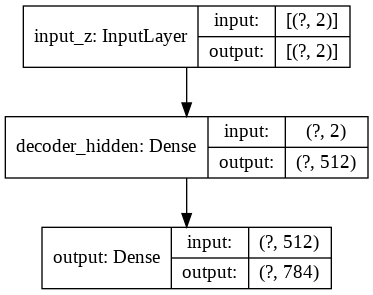

In [6]:
# Z가 입력으로 들어오기 때문에 Z의 shape를 Input shape로 지정해줍니다.
input_z = layers.Input(shape=(latent_dim,), name='input_z')
decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)
outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden)

# 디코더 모델은 잠재변수 z가 입력으로 들어가고 복원값을 출력합니다. 
decoder = Model(input_z, outputs, name='decoder')

# 디코더의 네트워크를 확인합니다.
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

### (3) VAE모델 생성

In [0]:
def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy 
    inputs, outputs = x, recon_x
    reconstruction_loss = binary_crossentropy(inputs,outputs)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * math.reduce_sum(math.square(z_mean)+ math.exp(z_log_sigma)- 2*z_log_sigma -1, 1)    
    return math.reduce_mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

# build VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

## 모델학습시작

In [18]:

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae.fit(x_train, x_train, epochs=50, batch_size=64)

#학습된 VAE 모델 저장 
vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 14s 235us/sample - loss: 0.0421
Epoch 2/50
60000/60000 [==============================] - 14s 234us/sample - loss: 0.0414
Epoch 3/50
60000/60000 [==============================] - 14s 234us/sample - loss: 0.0409
Epoch 4/50
60000/60000 [==============================] - 14s 235us/sample - loss: 0.0405
Epoch 5/50
60000/60000 [==============================] - 14s 237us/sample - loss: 0.0402
Epoch 6/50
60000/60000 [==============================] - 14s 238us/sample - loss: 0.0398
Epoch 7/50
60000/60000 [==============================] - 14s 236us/sample - loss: 0.0395
Epoch 8/50
60000/60000 [==============================] - 14s 233us/sample - loss: 0.0393
Epoch 9/50
60000/60000 [==============================] - 14s 235us/sample - loss: 0.0391
Epoch 10/50
60000/60000 [==============================] - 14s 235us/sample - loss: 0.0389
Epoch 11/50
60000/60000 [==============================] - 14s 239us/sample 

## 원본이미지와 복원이미지 비교

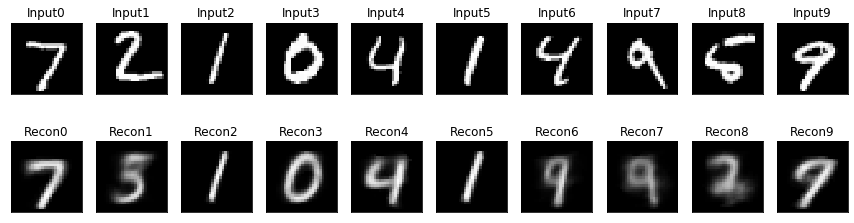

In [19]:
recon_x_test = vae.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(28, 28),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()

## 2D공간에 잠재된 데이터 출력

In [0]:
# 학습모델이 생성한 Manifold를 plot하는 함수 정의
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    filename = "digits_over_latent.png"
    # display a 30x30 2D manifold of digitsa
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

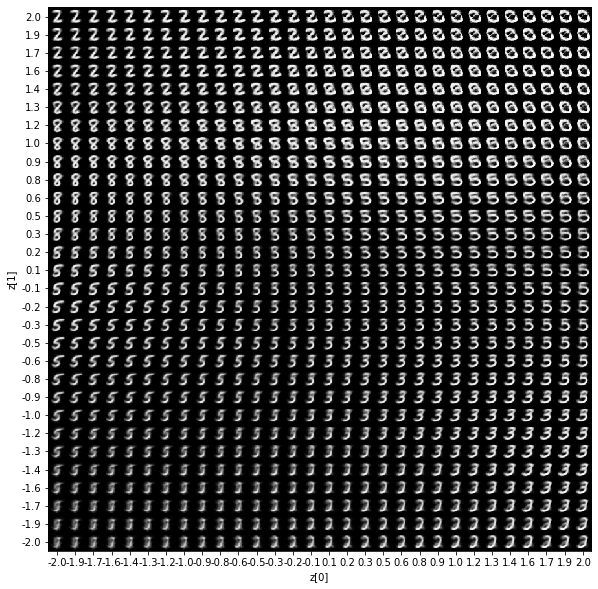

In [21]:
plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

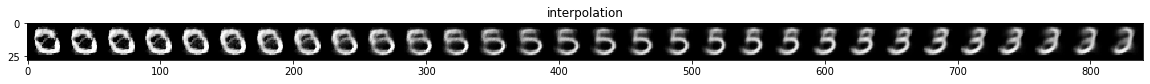

In [22]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

canvas = np.empty((28, 28*n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_hat = decoder.predict(z_sample)
        canvas[:, i*28: (i+1)*28] = x_hat[0].reshape(28, 28)
fig, ax = plt.subplots(figsize=(20,20))             
plt.title("interpolation")
ax.imshow(canvas, cmap="gray")

## Reference
*   https://www.tensorflow.org/guide/keras/custom_layers_and_models?hl=ko
*   https://www.tensorflow.org/tutorials/generative/cvae